# Moyens de paiements des clients

Analyse du jeu de données "Order_payments_datas" et agrégation avec un jeu préexistant à définir.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

order_payments_datas = pd.read_csv("olist_order_payments_dataset.csv")
order_payments_datas

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54


Pour commencer, il faut définir ce que sont exactement les features "payment_sequential" et "payment_installments".

Après quelques recherches:
* "payment_sequential" semble l'ordre des paiements pour une commande. La valeur est incrémentée de 1 pour chaque nouveau paiement
* "payment_installments" est l'équivalent des paiements en plusieurs fois. La valeur correspond au nombre de périodes sur l'échéancier

Cela laisse donc penser que pour une commande, le client peut payer avec différents moyens de paiement pris en compte les uns après les autres ("payment_sequential") et que pour chaque moyen de paiement, ce dernier peut être divisé en plusieurs créances ("payment_installments").

1. Je suppose donc que je devrais trouver plusieurs fois le même "order_id" associé à des "payment_sequential" ayant un certain nombre de valeurs croissantes.

2. Quant à "payment_installments", je vais garder toutes les valeurs supérieures à 1 et regarder si elles sont liées à une valeur unique de "order_id ou pas et donc par extension à plusieurs moyens de paiements.

De là découle qu'il faudra comparer "payment_value" avec la valeur totale des produits achetés + (ou pas) les frais de port. Soit il y aura égalité parfaite, soit "payment_value" est un multiple du prix total, le multiple étant possiblement en lien avec le nombre de paiements et "payment_installments".

J'en déduis que je vais agréger ce jeu de données à "Items_datas"

Mais avant tout, regardons la feature "payment_type".

In [2]:
print(f"Il y a {order_payments_datas['payment_type'].nunique()} moyens de paiements")
print(f" Ces derniers sont:\n{order_payments_datas['payment_type'].unique()}\nrépartis comme suit:")
order_payments_datas["payment_type"].value_counts()

Il y a 5 moyens de paiements
 Ces derniers sont:
['credit_card' 'boleto' 'voucher' 'debit_card' 'not_defined']
répartis comme suit:


credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

* Credit card => carte de crédit
* Boleto => équivalent à un chèque?
* Voucher => bon
* Debit card => carte de débit
* Not defined => non défini

Différence entre carte de crédit et carte de débit:
* carte de crédit => prélèvement sur le compte de tous les paiements en une seule fois à la fin du mois 
* carte de débit => prélèvement sur le compte des paiements à chaque transaction

Je peux retirer les moyens de paiement non définis.

In [3]:
payment_datas = order_payments_datas[order_payments_datas["payment_type"] != "not_defined"].copy()

### 1. Payment_sequential

In [4]:
id_counts = payment_datas["order_id"].value_counts().reset_index()
id_counts

,index,order_id
0,fa65dad1b0e818e3ccc5cb0e39231352,29
1,ccf804e764ed5650cd8759557269dc13,26
2,285c2e15bebd4ac83635ccc563dc71f4,22
3,895ab968e7bb0d5659d16cd74cd1650c,21
4,fedcd9f7ccdc8cba3a18defedd1a5547,19
...,...,...
99432,a7737f6d9208dd56ea498a322ed3c37f,1
99433,646e62df54f3e236eb6d5ff3b31429b8,1
99434,e115da7a49ec2acf622e1f31da65cfb9,1
99435,f22592e01ddc0711e6794f900fa5e787,1


Il y a bien plusieurs moyens de paiement pour certaines commandes.


Ca pourrait être bien de savoir si lors de paiements par de multiples moyens, le même type de paiement est toujours utilisé.

In [5]:
test = payment_datas.groupby(["order_id", "payment_type"]).agg({"payment_sequential": ["count", "min", "max"], "payment_value": 
    ["count", "min", "max", "mean", "sum"], "payment_installments": ["count", "min", "max", "mean"]}).reset_index()
test.loc[test["order_id"] == test["order_id"].value_counts().reset_index().iloc[0, 0], :].reset_index(drop=True)

order_id payment_type payment_sequential          \
                                                              count min max   
0  ea461a2421a4be04b0d69e11e12788ca  credit_card                  1   1   1   
1  ea461a2421a4be04b0d69e11e12788ca      voucher                  1   2   2   

  payment_value                             payment_installments               
          count    min    max   mean    sum                count min max mean  
0             1  50.12  50.12  50.12  50.12                    1   1   1  1.0  
1             1   7.08   7.08   7.08   7.08                    1   1   1  1.0

On peut constater qu'il peut y avoir plusieurs moyens de paiement différents pour une même commande.

### 2. Payment installments

In [6]:
sup1 = payment_datas[payment_datas["payment_installments"] > 1]
order_test = sup1["order_id"].value_counts().reset_index().iloc[5, 0]
test_sup = sup1.loc[sup1["order_id"] == order_test]
test_sup


,order_id,payment_sequential,payment_type,payment_installments,payment_value
47812,7797659fa7b8f16a68562da5976d179e,1,credit_card,2,50.00
97564,7797659fa7b8f16a68562da5976d179e,2,credit_card,2,54.95


Il y a des commandes où l'on trouve plusieurs moyens de paiement chacun assorti d'un échéancier.

Quel type de paiement est utilisé pour mettre en place le paiement en plusieurs fois?

In [7]:
sup1["payment_type"].unique()

array(['credit_card'], dtype=object)

Les cartes de crédit sont l'unique moyen utilisé pour mettre en place un paiement en plusieurs fois.

Avant de mettre de l'ordre dans le jeu de données, il faut comparer la feature "payment_value" avec les différentes valeurs du jeu "Items_datas". Je vais utiliser l' "order_id" test ci-dessus.

In [8]:
items_datas = pd.read_csv("POLIST_05_items_datas.csv")
test_items = items_datas.loc[items_datas["order_id"] == order_test]
test_items

,order_id,price_min,price_mean,price_max,price_sum,freight_value_min,freight_value_mean,freight_value_max,freight_value_sum,product_description_lenght_min,product_description_lenght_mean,product_description_lenght_max,product_photos_qty_min,product_photos_qty_mean,product_photos_qty_max,weight_min,weight_mean,weight_max,nb_product_min,nb_product_mean,nb_product_max,nb_product_sum,category__agro_industry_and_commerce,category__air_conditioning,category__art,category__arts_and_craftmanship,category__audio,category__auto,category__baby,category__bed_bath_table,category__books_general_interest,category__books_imported,category__books_technical,category__cds_dvds_musicals,category__christmas_supplies,category__cine_photo,category__computers,category__computers_accessories,category__consoles_games,category__construction_tools_construction,category__construction_tools_lights,category__construction_tools_safety,category__cool_stuff,category__costruction_tools_garden,category__costruction_tools_tools,category__diapers_and_hygiene,category__drinks,category__dvds_blu_ray,category__electronics,category__fashio_female_clothing,category__fashion_bags_accessories,category__fashion_childrens_clothes,category__fashion_male_clothing,category__fashion_shoes,category__fashion_sport,category__fashion_underwear_beach,category__fixed_telephony,category__flowers,category__food,category__food_drink,category__furniture_bedroom,category__furniture_decor,category__furniture_living_room,category__furniture_mattress_and_upholstery,category__garden_tools,category__health_beauty,category__home_appliances,category__home_appliances_2,category__home_comfort_2,category__home_confort,category__home_construction,category__housewares,category__industry_commerce_and_business,category__kitchen_dining_laundry_garden_furniture,category__kitchen_laptops_and_food_preparers,category__la_cuisine,category__luggage_accessories,category__market_place,category__music,category__musical_instruments,category__office_furniture,category__others,category__party_supplies,category__pc_gamer,category__perfumery,category__pet_shop,category__security_and_services,category__signaling_and_security,category__small_appliances,category__small_appliances_home_oven_and_coffee,category__sports_leisure,category__stationery,category__tablets_printing_image,category__telephony,category__toys,category__watches_gifts,seller_state__AC,seller_state__AM,seller_state__BA,seller_state__CE,seller_state__DF,seller_state__ES,seller_state__GO,seller_state__MA,seller_state__MG,seller_state__MS,seller_state__MT,seller_state__PA,seller_state__PB,seller_state__PE,seller_state__PI,seller_state__PR,seller_state__RJ,seller_state__RN,seller_state__RO,seller_state__RS,seller_state__SC,seller_state__SE,seller_state__SP
44300,7797659fa7b8f16a68562da5976d179e,79.9,79.9,79.9,79.9,25.05,25.05,25.05,25.05,259.0,259.0,259.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
test_sup["payment_value"].sum() == test_items["price_sum"] + test_items["freight_value_sum"]

44300    True
dtype: bool

Il semblerait que le montant total payé par l'acheteur correspond bien à la somme des produits + frais de port dans le jeu "Items_datas" mais aussi à la somme des valeurs de "payment_value" du jeu "Payments_datas". Il faut vérifier cela sur l'ensemble des données.

La valeur de "payment_installments" ne semble pas influer sur le calcul. Par contre, on peut en déduire les montants pour chaque échéancier émis.

***Après avoir vu les résultats de la fonction suivante, je vais la réécrire pour séparer les commandes ayant une différence de montants incluant des paiements voucher des autres.***

In [10]:
from sklearn.preprocessing import OneHotEncoder

X = payment_datas["payment_type"].to_numpy().reshape(-1, 1)

ohe = OneHotEncoder().fit(X)
type_ohe = pd.DataFrame(ohe.transform(X).toarray(), columns= ohe.get_feature_names_out(["type_"]), index= payment_datas.index)

In [11]:
payment_datas = payment_datas.merge(type_ohe, left_index=True, right_index=True)


In [12]:
payment_datas

,order_id,payment_sequential,payment_type,payment_installments,payment_value,type__boleto,type__credit_card,type__debit_card,type__voucher
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,0.0,1.0,0.0,0.0
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,0.0,1.0,0.0,0.0
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,0.0,1.0,0.0,0.0
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,0.0,1.0,0.0,0.0
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31,1.0,0.0,0.0,0.0
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80,0.0,1.0,0.0,0.0
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77,0.0,1.0,0.0,0.0
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54,0.0,1.0,0.0,0.0


***Pour la suite, je me suis rendu compte que beaucoup d'individus ont un écart de +/- 0.01 entre la somme du prix des produits + frais de port et la somme des paiements effectifs. Cette différence vient dans majorité des cas d'un souci d'arrondis lors du calcul du montant à payer.***

In [13]:
items_cols = ["price_sum", "freight_value_sum"]
payment_cols = "payment_value"
install_cols = "payment_installments"

In [14]:
def test_total(items_data, payment_data, sort_col, items_cols, payment_cols, install_cols):
    # identifier les commandes uniques d' items_data
    unique_id = items_data[sort_col].unique().tolist()

    # créer liste vide pour commandes uniques fausses
    list_val = []
    list_vouch = []

    # boucler sur les commandes uniques de items_data
    for i in range(len(unique_id)):
        # extraire la somme des valeurs des features items_cols de items_data
        items_sum = items_data.loc[items_data[sort_col] == unique_id[i], items_cols].to_numpy().sum().round(2)

        # extraire la somme des valeurs des features payment_cols de payment_data
        try:
            payment_tmp = payment_data.loc[(payment_data[sort_col] == unique_id[i]), :] #.to_numpy().sum().round(2)
            payment_gpb = payment_tmp.groupby(sort_col).sum().round(2).reset_index()
            payment_sum = payment_gpb[payment_cols][0].round(2)
        except Exception as e:
            # return print(f"i= {i}\n{e}")
            continue

        # comparer les valeurs et liste.append(id commande, payment_installments, items_sum, payment_sum, diff_sum, perc_sum) si false
        diff = np.round(payment_sum - items_sum, 2)
        if diff < -0.02 or diff > 0.02:

            installment = payment_data.loc[payment_data[sort_col] == unique_id[i], install_cols].tolist()

            truc = payment_data.loc[payment_data[sort_col] == unique_id[i], "payment_type"].tolist()
            if len(installment) == 0 or len(truc) == 0:
                continue

            if payment_gpb["type__voucher"][0] > 0:
                list_vouch.append([unique_id[i], installment, items_sum, payment_sum, diff, np.round((payment_sum / items_sum -1) *100, 0), 
                    payment_gpb["type__boleto"][0], payment_gpb["type__credit_card"][0], payment_gpb["type__debit_card"][0], 
                    payment_gpb["type__voucher"][0]])
            else:
                list_val.append([unique_id[i], installment, items_sum, payment_sum, diff, np.round((payment_sum / items_sum -1) *100, 0), 
                    payment_gpb["type__boleto"][0], payment_gpb["type__credit_card"][0], payment_gpb["type__debit_card"][0]])

        if i == 100:
            voucher_pay = pd.DataFrame(list_vouch, columns=["order_id", "installments", "items_sum", "payment_sum", "diff", "perc", 
                "type__boleto", "type__credit_card", "type__debit_card", "type_voucher"])
            other_pay = pd.DataFrame(list_val, columns=["order_id", "installments", "items_sum", "payment_sum", "diff", "perc", 
                "type__boleto", "type__credit_card", "type__debit_card"])
            return voucher_pay, other_pay


In [15]:
# voucher_results, others_results = test_total(items_datas, payment_datas, "order_id", items_cols, payment_cols, install_cols)
# voucher_results.to_csv("POLIST_09_voucher_results.csv", index=False)
# others_results.to_csv("POLIST_09_others_results", index=False)

In [16]:
voucher_results = pd.read_csv("POLIST_09_voucher_results.csv")
others_results = pd.read_csv("POLIST_09_others_results")

J'ai pour intuition que la différence de montant total pour:
* credit card est lié au nombre d'échéances
* boleto => taxe?
* voucher == bon donc montant non remboursable du bon en plus par rapport au prix de l'article

~~***Il faut que je pense à regarder si les montants retirés et ajoutés sont liés au client. Ex: -0.01 sur une commande puis +0.01 sur la prochaine.***~~ 
= > Pas valable. Les écarts de quelques centimes sont dûs au arrondis.

In [17]:
voucher_results

,order_id,installments,items_sum,payment_sum,diff,perc,type__boleto,type__credit_card,type__debit_card,type_voucher
0,1c11d0f4353b31ac3417fbfa5f0f2a8a,"[1, 1, 1]",421.70,421.69,-0.01,-0.0,0.0,1.0,0.0,2.0
1,8ac5b235603eee2e21e36261b2df536c,"[5, 1]",116.65,116.66,0.01,0.0,0.0,1.0,0.0,1.0
2,dceb62e8fa94b46006c9554fed743df0,"[1, 1, 1, 1]",330.07,330.06,-0.01,-0.0,0.0,1.0,0.0,3.0
3,4ed127b02fb1ebdaf9a0e4be8ca000f9,"[1, 1]",370.95,370.94,-0.01,-0.0,0.0,1.0,0.0,1.0
4,85d1f27ce2b79aafb89810ff41fc3e72,"[1, 1]",172.02,172.01,-0.01,-0.0,0.0,1.0,0.0,1.0
5,0f14db1abb2772e95d78a72c30d69678,"[10, 1]",209.04,209.05,0.01,0.0,0.0,1.0,0.0,1.0
6,711526597d2e1f1b5ee9bf5c4af2c4cf,"[6, 1]",768.12,768.11,-0.01,-0.0,0.0,1.0,0.0,1.0
7,30afdf98bd76676a199127199643a168,"[1, 1]",90.16,90.15,-0.01,-0.0,0.0,1.0,0.0,1.0
8,6aaedd714ad6929fc4df8d51bd4cfe9a,"[2, 1]",61.32,62.99,1.67,3.0,0.0,1.0,0.0,1.0
9,1e28e69f84e592969c53f666961fb156,[1],104.00,103.99,-0.01,-0.0,0.0,0.0,0.0,1.0


In [18]:
print(f"Il y a {len(voucher_results)} / {payment_datas['order_id'].nunique()} individus intégrant le paiement par voucher présentant une " +
    f"différence entre les montants totaux.")

Il y a 16 / 99437 individus intégrant le paiement par voucher présentant une différence entre les montants totaux.


In [19]:
others_results

,order_id,installments,items_sum,payment_sum,diff,perc,type__boleto,type__credit_card,type__debit_card
0,5a3b1c29a49756e75f1ef513383c0c12,[3],853.94,853.95,0.01,0.0,0.0,1.0,0.0
1,d5211af24819d319c02a285e7bb51750,[2],186.75,186.76,0.01,0.0,0.0,1.0,0.0
2,4412d97cb2093633afa85f11db46316c,[1],3195.74,3195.73,-0.01,-0.0,1.0,0.0,0.0
3,dc3adcf742779e0c8eb5bd587ed4ec57,[6],727.56,727.58,0.02,0.0,0.0,1.0,0.0
4,9bdf94af058f959fbc09c3ea1eb32465,[10],227.66,227.63,-0.03,-0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
555,585f3aa654c4d58eb968fc4fe6e3e92e,[10],89.63,101.31,11.68,13.0,0.0,1.0,0.0
556,63cb2376233663b05e9beb6bd9206c65,[8],72.94,84.25,11.31,16.0,0.0,1.0,0.0
557,e003d94282e5f1e45760dde794a8a173,"[7, 4]",116.32,125.06,8.74,8.0,0.0,2.0,0.0
558,2f722ee8f3d3db0d19cee8ebea6fa69e,[10],110.02,124.35,14.33,13.0,0.0,1.0,0.0


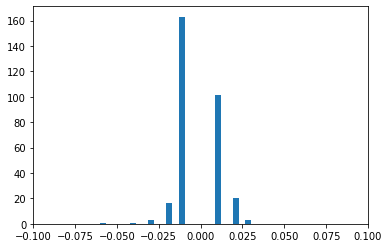

In [20]:
plt.hist(others_results.loc[(others_results["diff"] > -0.1) & (others_results["diff"] < 0.1), "diff"], bins= 25)
plt.xlim(-0.1, 0.1)

plt.show()

In [1]:
truc = len(others_results[(others_results["diff"] > 0.05) | (others_results["diff"] < -0.05)])
print(f"{truc} individus ayant un écart > +/- 0.05")
print(f"{len(others_results) - truc} individus ayant un écart < +/- 0.05")
print(f"Il y a {len(others_results) + len(voucher_results)} / {payment_datas['order_id'].nunique()} individus intégrant les autres paiement présentant une " +
    f"différence entre les montants totaux.")
print(f"Si je retire les individus ayant une différence entre les sommes, je perds " + 
    f"{np.round((len(others_results) + len(voucher_results)) / len(payment_datas) *100, 3)}% de données.")

NameError: name 'others_results' is not defined

In [22]:
n_payments_datas = payment_datas[(~payment_datas["order_id"].isin(others_results["order_id"])) & (~payment_datas["order_id"].isin(
    voucher_results["order_id"]))]

In [23]:
n_payments_datas

,order_id,payment_sequential,payment_type,payment_installments,payment_value,type__boleto,type__credit_card,type__debit_card,type__voucher
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33,0.0,1.0,0.0,0.0
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39,0.0,1.0,0.0,0.0
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71,0.0,1.0,0.0,0.0
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78,0.0,1.0,0.0,0.0
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31,1.0,0.0,0.0,0.0
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80,0.0,1.0,0.0,0.0
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77,0.0,1.0,0.0,0.0
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54,0.0,1.0,0.0,0.0


In [24]:
tmp_agg_payments = n_payments_datas.groupby("order_id").agg({"payment_sequential": "max", "payment_value": "sum", "payment_installments": 
    ["min", "max", "mean", "size"], "type__boleto": "sum", "type__credit_card": "sum", "type__debit_card": "sum", "type__voucher": "sum"}
    ).reset_index()
tmp_agg_payments

order_id payment_sequential payment_value  \
                                                       max           sum   
0      00010242fe8c5a6d1ba2dd792cb16214                  1         72.19   
1      00018f77f2f0320c557190d7a144bdd3                  1        259.83   
2      000229ec398224ef6ca0657da4fc703e                  1        216.87   
3      00024acbcdf0a6daa1e931b038114c75                  1         25.78   
4      00042b26cf59d7ce69dfabb4e55b4fd9                  1        218.04   
...                                 ...                ...           ...   
98856  fffc94f6ce00a00581880bf54a75a037                  1        343.40   
98857  fffcd46ef2263f404302a634eb57f7eb                  1        386.53   
98858  fffce4705a9662cd70adb13d4a31832d                  1        116.85   
98859  fffe18544ffabc95dfada21779c9644f                  1         64.71   
98860  fffe41c64501cc87c801fd61db3f6244                  1         55.79   

      payment_installments               type__boleto type__credit_card  \
                       min max mean size          sum               sum   
0                        2   2  2.0    1          0.0               1.0   
1                        3   3  3.0    1          0.0               1.0   
2                        5   5  5.0    1          0.0               1.0   
3                        2   2  2.0    1          0.0               1.0   
4                        3   3  3.0    1          0.0               1.0   
...                    ...  ..  ...  ...          ...               ...   
98856                    1   1  1.0    1          1.0               0.0   
98857                    1   1  1.0    1          1.0               0.0   
98858                    3   3  3.0    1          0.0               1.0   
98859                    3   3  3.0    1          0.0               1.0   
98860                    1   1  1.0    1          0.0               1.0   

      type__debit_card type__voucher  
                   sum           sum  
0                  0.0           0.0  
1                  0.0           0.0  
2                  0.0           0.0  
3                  0.0           0.0  
4                  0.0           0.0  
...                ...           ...  
98856              0.0           0.0  
98857              0.0           0.0  
98858              0.0           0.0  
98859              0.0           0.0  
98860              0.0           0.0  

[98861 rows x 11 columns]

Je peux agréger "Items_datas" et "Payment_datas".

In [25]:
items_datas

,order_id,price_min,price_mean,price_max,price_sum,freight_value_min,freight_value_mean,freight_value_max,freight_value_sum,product_description_lenght_min,product_description_lenght_mean,product_description_lenght_max,product_photos_qty_min,product_photos_qty_mean,product_photos_qty_max,weight_min,weight_mean,weight_max,nb_product_min,nb_product_mean,nb_product_max,nb_product_sum,category__agro_industry_and_commerce,category__air_conditioning,category__art,category__arts_and_craftmanship,category__audio,category__auto,category__baby,category__bed_bath_table,category__books_general_interest,category__books_imported,category__books_technical,category__cds_dvds_musicals,category__christmas_supplies,category__cine_photo,category__computers,category__computers_accessories,category__consoles_games,category__construction_tools_construction,category__construction_tools_lights,category__construction_tools_safety,category__cool_stuff,category__costruction_tools_garden,category__costruction_tools_tools,category__diapers_and_hygiene,category__drinks,category__dvds_blu_ray,category__electronics,category__fashio_female_clothing,category__fashion_bags_accessories,category__fashion_childrens_clothes,category__fashion_male_clothing,category__fashion_shoes,category__fashion_sport,category__fashion_underwear_beach,category__fixed_telephony,category__flowers,category__food,category__food_drink,category__furniture_bedroom,category__furniture_decor,category__furniture_living_room,category__furniture_mattress_and_upholstery,category__garden_tools,category__health_beauty,category__home_appliances,category__home_appliances_2,category__home_comfort_2,category__home_confort,category__home_construction,category__housewares,category__industry_commerce_and_business,category__kitchen_dining_laundry_garden_furniture,category__kitchen_laptops_and_food_preparers,category__la_cuisine,category__luggage_accessories,category__market_place,category__music,category__musical_instruments,category__office_furniture,category__others,category__party_supplies,category__pc_gamer,category__perfumery,category__pet_shop,category__security_and_services,category__signaling_and_security,category__small_appliances,category__small_appliances_home_oven_and_coffee,category__sports_leisure,category__stationery,category__tablets_printing_image,category__telephony,category__toys,category__watches_gifts,seller_state__AC,seller_state__AM,seller_state__BA,seller_state__CE,seller_state__DF,seller_state__ES,seller_state__GO,seller_state__MA,seller_state__MG,seller_state__MS,seller_state__MT,seller_state__PA,seller_state__PB,seller_state__PE,seller_state__PI,seller_state__PR,seller_state__RJ,seller_state__RN,seller_state__RO,seller_state__RS,seller_state__SC,seller_state__SE,seller_state__SP
0,ca3625898fbd48669d50701aba51cd5f,33.9,113.83,309.0,1138.30,0.15,1.90,3.68,18.98,338.0,338.38,339.0,1.0,1.00,1.0,0.07105,0.12,0.20517,1,1.25,2,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
1,ad850e69fce9a512ada84086651a2e7d,99.0,156.14,299.0,1093.00,16.61,21.37,33.24,149.57,2010.0,2019.43,2043.0,2.0,2.86,5.0,0.10485,0.14,0.23787,1,1.00,1,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7d8f5bfd5aff648220374a2df62e84d5,69.0,80.43,89.0,563.00,0.48,2.85,6.01,19.94,337.0,337.71,339.0,1.0,1.00,1.0,0.10799,0.14,0.16901,1,1.00,1,7,0.0,

In [26]:
pay_items_datas = tmp_agg_payments.merge(items_datas, on="order_id")
pay_items_datas

C:\Users\nanar\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:9190: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  return merge(


,order_id,"(order_id, )","(payment_sequential, max)","(payment_value, sum)","(payment_installments, min)","(payment_installments, max)","(payment_installments, mean)","(payment_installments, size)","(type__boleto, sum)","(type__credit_card, sum)","(type__debit_card, sum)","(type__voucher, sum)",price_min,price_mean,price_max,price_sum,freight_value_min,freight_value_mean,freight_value_max,freight_value_sum,product_description_lenght_min,product_description_lenght_mean,product_description_lenght_max,product_photos_qty_min,product_photos_qty_mean,product_photos_qty_max,weight_min,weight_mean,weight_max,nb_product_min,nb_product_mean,nb_product_max,nb_product_sum,category__agro_industry_and_commerce,category__air_conditioning,category__art,category__arts_and_craftmanship,category__audio,category__auto,category__baby,category__bed_bath_table,category__books_general_interest,category__books_imported,category__books_technical,category__cds_dvds_musicals,category__christmas_supplies,category__cine_photo,category__computers,category__computers_accessories,category__consoles_games,category__construction_tools_construction,category__construction_tools_lights,category__construction_tools_safety,category__cool_stuff,category__costruction_tools_garden,category__costruction_tools_tools,category__diapers_and_hygiene,category__drinks,category__dvds_blu_ray,category__electronics,category__fashio_female_clothing,category__fashion_bags_accessories,category__fashion_childrens_clothes,category__fashion_male_clothing,category__fashion_shoes,category__fashion_sport,category__fashion_underwear_beach,category__fixed_telephony,category__flowers,category__food,category__food_drink,category__furniture_bedroom,category__furniture_decor,category__furniture_living_room,category__furniture_mattress_and_upholstery,category__garden_tools,category__health_beauty,category__home_appliances,category__home_appliances_2,category__home_comfort_2,category__home_confort,category__home_construction,category__housewares,category__industry_commerce_and_business,category__kitchen_dining_laundry_garden_furniture,category__kitchen_laptops_and_food_preparers,category__la_cuisine,category__luggage_accessories,category__market_place,category__music,category__musical_instruments,category__office_furniture,category__others,category__party_supplies,category__pc_gamer,category__perfumery,category__pet_shop,category__security_and_services,category__signaling_and_security,category__small_appliances,category__small_appliances_home_oven_and_coffee,category__sports_leisure,category__stationery,category__tablets_printing_image,category__telephony,category__toys,category__watches_gifts,seller_state__AC,seller_state__AM,seller_state__BA,seller_state__CE,seller_state__DF,seller_state__ES,seller_state__GO,seller_state__MA,seller_state__MG,seller_state__MS,seller_state__MT,seller_state__PA,seller_state__PB,seller_state__PE,seller_state__PI,seller_state__PR,seller_state__RJ,seller_state__RN,seller_state__RO,seller_state__RS,seller_state__SC,seller_state__SE,seller_state__SP
0,00010242fe8c5a6d1ba2dd792cb16214,00010242fe8c5a6d1ba2dd792cb16214,1,72.19,2,2,2.0,1,0.0,1.0,0.0,0.0,58.90,58.90,58.90,58.90,13.29,13.29,13.29,13.29,598.0,598.0,598.0,4.0,4.0,4.0,1.0,1.0,1.0,1,1.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,00018f77f2f0320c557190d7a144bdd3,00018f77f2f0320c557190d7a144bdd3,1,259.83,3,3,3.0,1,0.0,1.0,0.0,0.0,239.90,239.90,239.90,239.90,19.93,19.93,19.93,19.93,239.0,239.0,239.0,2.0,2.0,2.0,1.0,1.0,1.0,1,1.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [27]:
pay_items_datas = pay_items_datas.drop(columns=("order_id",""))
pay_items_datas = pay_items_datas.rename(columns={("payment_sequential", "max"): "sequential_max", ("payment_value", "sum"): "pay_sum", 
    ("payment_installments", "min"): "installments_min", ("payment_installments", "max"): "installments_max", ("payment_installments", "mean"): 
    "installments_mean", ("payment_installments", "size"): "installments_size", ("type__boleto", "sum"): "type_boleto", 
    ("type__credit_card", "sum"): "type_credit_card", ("type__debit_card", "sum"): "type_debit_card", ("type__voucher", "sum"): "type_voucher"})

pay_items_datas

,order_id,sequential_max,pay_sum,installments_min,installments_max,installments_mean,installments_size,type_boleto,type_credit_card,type_debit_card,type_voucher,price_min,price_mean,price_max,price_sum,freight_value_min,freight_value_mean,freight_value_max,freight_value_sum,product_description_lenght_min,product_description_lenght_mean,product_description_lenght_max,product_photos_qty_min,product_photos_qty_mean,product_photos_qty_max,weight_min,weight_mean,weight_max,nb_product_min,nb_product_mean,nb_product_max,nb_product_sum,category__agro_industry_and_commerce,category__air_conditioning,category__art,category__arts_and_craftmanship,category__audio,category__auto,category__baby,category__bed_bath_table,category__books_general_interest,category__books_imported,category__books_technical,category__cds_dvds_musicals,category__christmas_supplies,category__cine_photo,category__computers,category__computers_accessories,category__consoles_games,category__construction_tools_construction,category__construction_tools_lights,category__construction_tools_safety,category__cool_stuff,category__costruction_tools_garden,category__costruction_tools_tools,category__diapers_and_hygiene,category__drinks,category__dvds_blu_ray,category__electronics,category__fashio_female_clothing,category__fashion_bags_accessories,category__fashion_childrens_clothes,category__fashion_male_clothing,category__fashion_shoes,category__fashion_sport,category__fashion_underwear_beach,category__fixed_telephony,category__flowers,category__food,category__food_drink,category__furniture_bedroom,category__furniture_decor,category__furniture_living_room,category__furniture_mattress_and_upholstery,category__garden_tools,category__health_beauty,category__home_appliances,category__home_appliances_2,category__home_comfort_2,category__home_confort,category__home_construction,category__housewares,category__industry_commerce_and_business,category__kitchen_dining_laundry_garden_furniture,category__kitchen_laptops_and_food_preparers,category__la_cuisine,category__luggage_accessories,category__market_place,category__music,category__musical_instruments,category__office_furniture,category__others,category__party_supplies,category__pc_gamer,category__perfumery,category__pet_shop,category__security_and_services,category__signaling_and_security,category__small_appliances,category__small_appliances_home_oven_and_coffee,category__sports_leisure,category__stationery,category__tablets_printing_image,category__telephony,category__toys,category__watches_gifts,seller_state__AC,seller_state__AM,seller_state__BA,seller_state__CE,seller_state__DF,seller_state__ES,seller_state__GO,seller_state__MA,seller_state__MG,seller_state__MS,seller_state__MT,seller_state__PA,seller_state__PB,seller_state__PE,seller_state__PI,seller_state__PR,seller_state__RJ,seller_state__RN,seller_state__RO,seller_state__RS,seller_state__SC,seller_state__SE,seller_state__SP
0,00010242fe8c5a6d1ba2dd792cb16214,1,72.19,2,2,2.0,1,0.0,1.0,0.0,0.0,58.90,58.90,58.90,58.90,13.29,13.29,13.29,13.29,598.0,598.0,598.0,4.0,4.0,4.0,1.0,1.0,1.0,1,1.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,00018f77f2f0320c557190d7a144bdd3,1,259.83,3,3,3.0,1,0.0,1.0,0.0,0.0,239.90,239.90,239.90,239.90,19.93,19.93,19.93,19.93,239.0,239.0,239.0,2.0,2.0,2.0,1.0,1.0,1.0,1,1.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [28]:
# pay_items_datas.to_csv("POLIST_09_pay_items_datas.csv", index=False)

Maintenant, il ne reste plus qu'à agréger le jeu de données nouvellement créé avec "Ord_reviews".

In [29]:
ord_reviews = pd.read_csv("POLIST_07_ord_reviews.csv")

In [30]:
f_datas = ord_reviews.merge(pay_items_datas, on= "order_id")
f_datas

,order_id,customer_unique_id,customer_state,delivering_time,delivered_before_time,nb_score,score_mean,init_score,diff_score,purchase_date,purchase_y_m,purchase_y_q,purchase_y_s,purchase_y,days_last_purchase,sequential_max,pay_sum,installments_min,installments_max,installments_mean,installments_size,type_boleto,type_credit_card,type_debit_card,type_voucher,price_min,price_mean,price_max,price_sum,freight_value_min,freight_value_mean,freight_value_max,freight_value_sum,product_description_lenght_min,product_description_lenght_mean,product_description_lenght_max,product_photos_qty_min,product_photos_qty_mean,product_photos_qty_max,weight_min,weight_mean,weight_max,nb_product_min,nb_product_mean,nb_product_max,nb_product_sum,category__agro_industry_and_commerce,category__air_conditioning,category__art,category__arts_and_craftmanship,category__audio,category__auto,category__baby,category__bed_bath_table,category__books_general_interest,category__books_imported,category__books_technical,category__cds_dvds_musicals,category__christmas_supplies,category__cine_photo,category__computers,category__computers_accessories,category__consoles_games,category__construction_tools_construction,category__construction_tools_lights,category__construction_tools_safety,category__cool_stuff,category__costruction_tools_garden,category__costruction_tools_tools,category__diapers_and_hygiene,category__drinks,category__dvds_blu_ray,category__electronics,category__fashio_female_clothing,category__fashion_bags_accessories,category__fashion_childrens_clothes,category__fashion_male_clothing,category__fashion_shoes,category__fashion_sport,category__fashion_underwear_beach,category__fixed_telephony,category__flowers,category__food,category__food_drink,category__furniture_bedroom,category__furniture_decor,category__furniture_living_room,category__furniture_mattress_and_upholstery,category__garden_tools,category__health_beauty,category__home_appliances,category__home_appliances_2,category__home_comfort_2,category__home_confort,category__home_construction,category__housewares,category__industry_commerce_and_business,category__kitchen_dining_laundry_garden_furniture,category__kitchen_laptops_and_food_preparers,category__la_cuisine,category__luggage_accessories,category__market_place,category__music,category__musical_instruments,category__office_furniture,category__others,category__party_supplies,category__pc_gamer,category__perfumery,category__pet_shop,category__security_and_services,category__signaling_and_security,category__small_appliances,category__small_appliances_home_oven_and_coffee,category__sports_leisure,category__stationery,category__tablets_printing_image,category__telephony,category__toys,category__watches_gifts,seller_state__AC,seller_state__AM,seller_state__BA,seller_state__CE,seller_state__DF,seller_state__ES,seller_state__GO,seller_state__MA,seller_state__MG,seller_state__MS,seller_state__MT,seller_state__PA,seller_state__PB,seller_state__PE,seller_state__PI,seller_state__PR,seller_state__RJ,seller_state__RN,seller_state__RO,seller_state__RS,seller_state__SC,seller_state__SE,seller_state__SP
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,SP,8.0,True,1,4.0,4,0,2017-10-02,201710,20174,20172,2017,331,3,38.71,1,1,1.0,3,0.0,1.0,0.0,2.0,29.99,29.99,29.99,29.99,8.72,8.72,8.72,8.72,268.0,268.0,268.0,4.0,4.0,4.0,1.0,1.0,1.0,1,1.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,BA,12.0,True,1,4.0,4,0,2018-07-24,201807,20183,20182,2018,36,1,141.46,1,1,1.0,1,1.0,0.0,0.0,0.0,118.70,118.70,118.70,118.70,22.76,22.76,22.76,22.76,178.0,178.0,

Il faut probablement faire du tri dans les données mais ces dernières sont entièrement agrégées dans un unique jeu.

Il faut aussi grouper les données par client.

In [32]:
# f_datas.to_csv("POLIST_09_final_raw_dataset.csv", index=False)